In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import tqdm

In [5]:
import bnn.data
import bnn.functions
import bnn.layer
import bnn.loss
import bnn.network
import bnn.optimizer

/home/blustrini/miniconda3/envs/bnn/lib/python3.11/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [7]:
root='./data'
download=True
batch_size=int(2**11)
shuffle=True
include_last_if_uneven=True
binarise_thesh=0.5

train_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=True,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)
test_MNIST_loader = bnn.data.MNISTDataLoader(
    root=root,
    download=download,
    train=False,
    batch_size=batch_size,
    shuffle=shuffle,
    include_last_if_uneven=include_last_if_uneven,
    binarise_thresh=binarise_thesh,
)

In [8]:
for batch_id, datum in enumerate(tqdm.tqdm(test_MNIST_loader)):
    if batch_id == 0:
        print(batch_id)
        print(torch.max(datum.input))
        print(torch.min(datum.input))
        print(datum.target)

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00, 15.58it/s]

0
tensor(1, dtype=torch.int32)
tensor(-1, dtype=torch.int32)
tensor([[-1, -1, -1,  ..., -1, -1,  1],
        [-1, -1, -1,  ..., -1,  1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        ...,
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1, -1,  ..., -1, -1, -1],
        [-1, -1,  1,  ..., -1, -1, -1]], dtype=torch.int32)


100%|██████████| 5/5 [00:00<00:00, 18.29it/s]


In [9]:
len(test_MNIST_loader), len(train_MNIST_loader)

(5, 30)

In [10]:
forward_func = bnn.functions.forward.SignBinarise()
#forward_func=bnn.functions.forward.LayerMeanBinarise()
#forward_func=bnn.functions.forward.LayerMedianBinarise()

In [11]:
backward_func = bnn.functions.backward.SignTernarise()
#backward_func = bnn.functions.backward.StochasticTernarise()
#backward_func = bnn.functions.backward.LayerMeanStdTernarise(half_range_stds=0.5)
#backward_func = bnn.functions.backward.LayerQuantileTernarise(lo=0.25, hi=0.75)
#backward_func = bnn.functions.backward.LayerQuantileSymmetricTernarise(prop_zero=0.5)
#backward_func = bnn.functions.backward.ActualGradient()

In [12]:
INPUT_DIM = bnn.data.MNISTDataLoader.input_size
OUTPUT_DIM = bnn.data.MNISTDataLoader.output_size

In [13]:
hidden = 8192

AP_ARCH = False
if AP_ARCH:
    vote_bits = 128

    dims = [INPUT_DIM, hidden, hidden, hidden, OUTPUT_DIM * vote_bits]
    n_layers = len(dims) - 1

    forward_funcs = [forward_func] * (n_layers - 1) + [bnn.functions.forward.BitCountMax(out_dims=OUTPUT_DIM, extra_dims=vote_bits)]
    backward_funcs = [backward_func] * (n_layers - 1) + [bnn.functions.backward.BackwardBitCountMax(extra_dims=vote_bits)]
else:
    dims = [INPUT_DIM, OUTPUT_DIM]
    n_layers = len(dims) - 1

    forward_funcs = [forward_func] * (n_layers - 1) + [bnn.functions.forward.OneHot()]
    backward_funcs = [backward_func] * n_layers

In [14]:
TBNN = bnn.network.TernBinNetwork(
    dims,
    forward_func=forward_funcs,
    backward_func=backward_funcs,
)
TBNN._initialise(W_mean=0, W_zero_prob=0.5)

In [15]:
TBNN.to(device)
train_MNIST_loader.to(device)
test_MNIST_loader.to(device)

In [16]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [17]:
BernOpt = bnn.optimizer.ExpectationSGD(TBNN.parameters(), lr=5e-5)
#BernOpt = bnn.optimizer.DeterministicSGD(TBNN.parameters(), lr=1e-3)

In [18]:
losses = []
test_accs = []
test_accs_epochs = []

In [19]:
train_epochs = 40
num_logs = 10
epoch_log_rate = train_epochs // num_logs

if epoch_log_rate == 0:
    epoch_log_rate = 1

In [20]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_onehot = TBNN.forward(batch.input)
    output_argmax = torch.argmax(output_onehot, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 13.46it/s]

accuracy: 0.10599999874830246


In [21]:
output_onehot.shape

torch.Size([1808, 10])

In [22]:
zero_loss_count = 0
zero_loss_count_for_early_stop = 10
for epoch in tqdm.trange(train_epochs):
    datapoints = 0
    epoch_loss = 0
    prop_flipped = 0
    for batch_id, batch in enumerate(train_MNIST_loader):
        # count ds
        batch_datapoints = len(batch.input)
        datapoints += batch_datapoints

        # forward pass and loss
        output = TBNN.forward(batch.input)
        batch_loss = loss_func.forward(output=output, target=batch.target)

        # backward pass
        grad = loss_func.backward(output=output, target=batch.target)
        out_grad = TBNN.backward(grad)

        # optimizer step
        batch_flipped, _, _ = BernOpt.step()
        prop_flipped += batch_flipped

        # sum loss
        epoch_loss += (batch_loss - epoch_loss) * batch_datapoints / datapoints

    # save loss
    losses.append(epoch_loss.cpu())

    if epoch_loss == 0:
        zero_loss_count += 1
    else:
        zero_loss_count = 0

    early_exit = zero_loss_count >= zero_loss_count_for_early_stop

    if early_exit or (epoch % epoch_log_rate) == 0:
        mean_prop_flipped = prop_flipped / (1 + batch_id)
        print(f'epoch: {epoch}\tloss: {epoch_loss}\tmean_prop_flipped: {mean_prop_flipped}')

        # test
        test_num_correct = 0
        test_total = test_MNIST_loader._datapoints
        for batch_id, batch in enumerate(test_MNIST_loader):
            # forward pass and loss
            output = TBNN.forward(batch.input)

            output_argmax = torch.argmax(output, dim=-1)
            target_argmax = torch.argmax(batch.target, dim=-1)

            test_num_correct += torch.sum(target_argmax == output_argmax)

        test_acc = test_num_correct / test_total
        test_accs.append(test_acc.cpu())
        test_accs_epochs.append(epoch)
        print(f"test accuracy: {test_acc}")

    if early_exit:
        break

  0%|          | 0/40 [00:00<?, ?it/s]

epoch: 0	loss: 3.383666753768921	mean_prop_flipped: 0.0006717687356285751


  2%|▎         | 1/40 [00:02<01:27,  2.23s/it]

test accuracy: 0.23429998755455017


 10%|█         | 4/40 [00:07<01:00,  1.69s/it]

epoch: 4	loss: 2.1063332557678223	mean_prop_flipped: 0.000182823117938824


 12%|█▎        | 5/40 [00:09<01:02,  1.79s/it]

test accuracy: 0.5105999708175659


 20%|██        | 8/40 [00:14<00:56,  1.75s/it]

epoch: 8	loss: 1.5974665880203247	mean_prop_flipped: 0.00014880954404361546


 22%|██▎       | 9/40 [00:16<00:56,  1.82s/it]

test accuracy: 0.6191999912261963


 30%|███       | 12/40 [00:20<00:45,  1.62s/it]

epoch: 12	loss: 1.3570001125335693	mean_prop_flipped: 0.00012755101488437504


 32%|███▎      | 13/40 [00:22<00:46,  1.72s/it]

test accuracy: 0.664900004863739


 40%|████      | 16/40 [00:27<00:38,  1.62s/it]

epoch: 16	loss: 1.2361332178115845	mean_prop_flipped: 0.00011904761049663648


 42%|████▎     | 17/40 [00:29<00:40,  1.75s/it]

test accuracy: 0.6992999911308289


 48%|████▊     | 19/40 [00:35<00:39,  1.87s/it]


KeyboardInterrupt: 

In [ ]:
for batch_id, batch in enumerate(tqdm.tqdm(train_MNIST_loader)):
    output = TBNN.forward(batch.input)

    # backward pass
    in_grad = loss_func.backward(output=output, target=batch.target)

    out_grad = {}
    TBNN.backward(in_grad)
    for name, grad in TBNN.grad.items():
        out_grad[name] = grad.data.cpu()

    out_grad_actual = {}
    TBNN.backward_actual(in_grad)
    for name, grad in TBNN.grad.items():
        out_grad_actual[name] = grad.data.cpu()

    out_grad_sign_agree = {}
    out_nonzero_grad_sign_agree = {}
    out_zero_grad_sign_agree = {}
    out_opposite_sign = {}
    out_nonzero_opposite_sign = {}
    for key in TBNN.layers:
        out_grad_sign = torch.sign(out_grad[key])
        actual_grad_sign = torch.sign(out_grad_actual[key])

        signs_agree = (out_grad_sign == actual_grad_sign)
        prop_agree = torch.mean(signs_agree.to(float)).item()
        nonzero_prop_agree = torch.mean(signs_agree[actual_grad_sign != 0].to(float)).item()
        zero_prop_agree = torch.mean(signs_agree[actual_grad_sign == 0].to(float)).item()

        out_grad_sign_agree[key] = prop_agree
        out_nonzero_grad_sign_agree[key] = nonzero_prop_agree
        out_zero_grad_sign_agree[key] = zero_prop_agree

        opposite_signs = (out_grad_sign * actual_grad_sign) == -1
        prop_opposite_signs = torch.mean(opposite_signs.to(torch.float)).item()
        prop_nonzero_opposite_signs = torch.mean(opposite_signs[actual_grad_sign != 0].to(torch.float)).item()

        out_opposite_sign[key] = prop_opposite_signs
        out_nonzero_opposite_sign[key] = prop_nonzero_opposite_signs

    break

print(out_grad_sign_agree)
print(out_nonzero_grad_sign_agree)
print(out_zero_grad_sign_agree)
print(out_opposite_sign)
print(out_nonzero_opposite_sign)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

{'TernBinLayer0': 0.9858105717873087, 'TernBinLayer1': 1.0}
{'TernBinLayer0': 0.907101763251947, 'TernBinLayer1': 1.0}
{'TernBinLayer0': 0.9993641226462134, 'TernBinLayer1': 1.0}
{'TernBinLayer0': 0.01263988297432661, 'TernBinLayer1': 0.0}
{'TernBinLayer0': 0.08604279160499573, 'TernBinLayer1': 0.0}


In [22]:
for key, layer in TBNN.layers.items():
    print(out_grad_actual[key].shape)
    print(out_grad_actual[key])
    print(torch.sum(out_grad_actual[key], dim=-1))
    print(out_grad[key])
    print(torch.sum(out_grad[key], dim=-1))

torch.Size([2048, 784])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
tensor([0, 0, 0,  ..., 0, 0, 0])
torch.Size([2048, 8192])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)
tensor([0, 0, 0,  ..., 0, 0, 0])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0,

In [23]:
num_correct = 0
total = test_MNIST_loader._datapoints
for batch_id, batch in enumerate(tqdm.tqdm(test_MNIST_loader)):
    # forward pass and loss
    output_onehot = TBNN.forward(batch.input)
    output_argmax = torch.argmax(output_onehot, dim=-1)
    target_argmax = torch.argmax(batch.target, dim=-1)

    num_correct += torch.sum(target_argmax == output_argmax)

print(f"accuracy: {num_correct / total}")

100%|██████████| 5/5 [00:00<00:00, 10.66it/s]

accuracy: 0.8545999526977539


In [24]:
input_ims = batch.input.cpu().reshape(-1, 28, 28)
input_class = target_argmax.cpu()
output_class = output_argmax.cpu()

input_class.shape

torch.Size([1808])

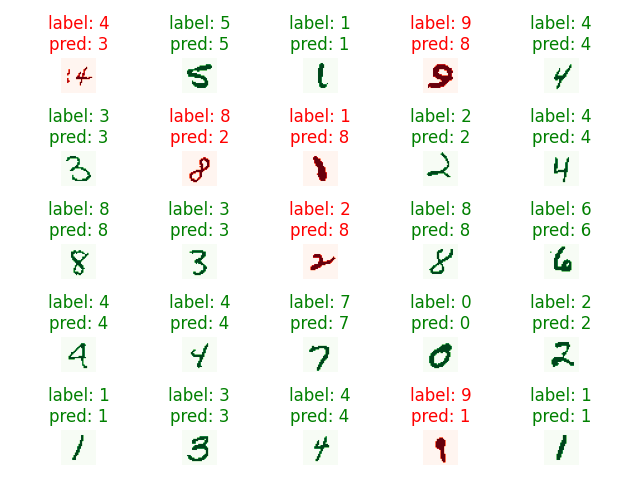

In [25]:
FIG_NAME = "preds"
plt.close(FIG_NAME)

num_plots = 25
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

for ax, in_im, in_cls, out_cls in zip(axs, input_ims, input_class, output_class):
    if in_cls == out_cls:
        c = "green"
        cmap = 'Greens'
    else:
        c = "red"
        cmap = 'Reds'
    ax.imshow(in_im, cmap=cmap)
    ax.set_title(f'label: {in_cls}\npred: {out_cls}', color=c)
    ax.axis('off')

fig.tight_layout()

plt.show()

In [26]:
k = 3
ins = torch.topk(output_onehot, k=k, dim=-1).indices
out = torch.zeros_like(output_argmax, dtype=bool)
for i in range(k):
    out |= ins[..., i] == target_argmax

torch.sum(out) / len(out)

tensor(0.8684, device='cuda:0')

In [27]:
import bnn.metrics

ds: list[bnn.random.DISCRETE_DIST | None] = []
for n, p in TBNN.named_parameters():
    if "W" in n:
        d = bnn.metrics.distribution(p.cpu())
        ds.append(d)

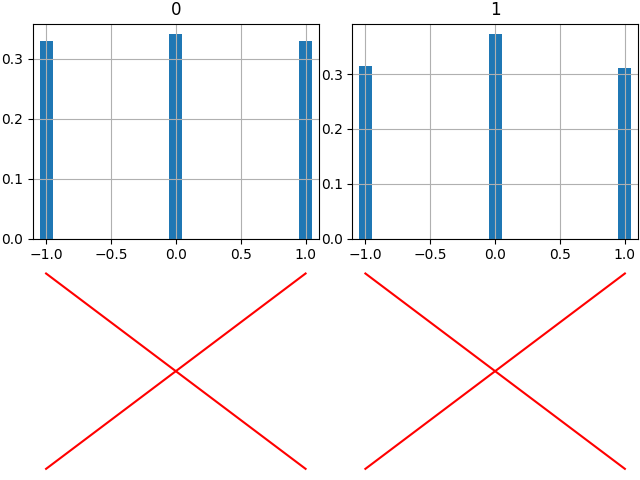

In [28]:
FIG_NAME = "dist"
plt.close(FIG_NAME)

num_plots = len(ds)
ceil_sqrt_num_plots = np.ceil(np.sqrt(num_plots)).astype(int)

fig, axs = plt.subplots(ceil_sqrt_num_plots, ceil_sqrt_num_plots, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1
width=0.1
for i, (ax, d) in enumerate(zip(axs, ds + [None]*len(axs))):
    if d is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(0, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(0, 1), '-', color="red")
        ax.axis("off")

    else:
        ax.set_title(i)
        vals = [pair.value for pair in d]
        probs = [pair.probability for pair in d]

        if len(vals) > 3:
            ax.plot(vals, probs, 'o-')
        else:
            ax.bar(vals, probs, width=width)

        min_x = min(min_x, min(vals))
        max_x = max(max_x, max(vals))

for ax in axs:
    ax.set_xlim(min_x-width, max_x+width)
    ax.grid()

fig.tight_layout(pad=0.1)
plt.show()

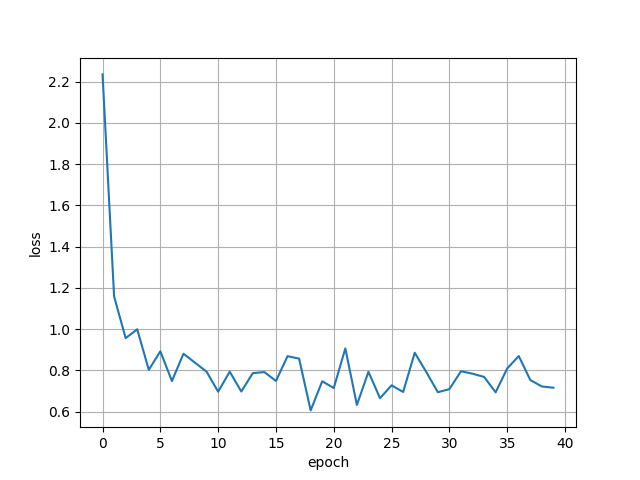

In [29]:
NAME = 'loss_curve'
plt.close(NAME)
plt.figure(NAME)

plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()

plt.show()

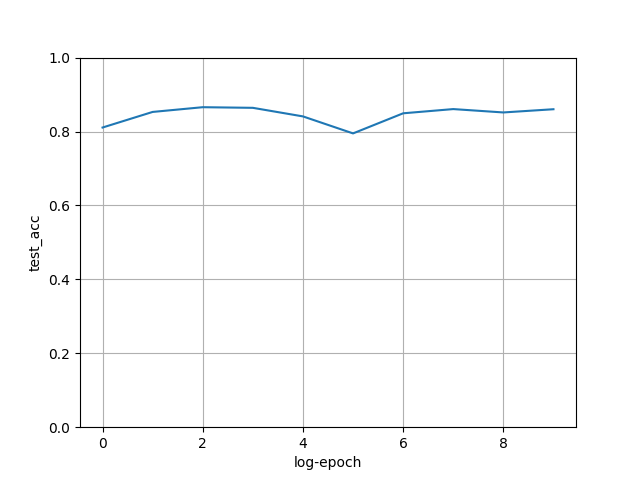

In [30]:
NAME = 'test_accs'
plt.close(NAME)
plt.figure(NAME)

plt.plot(test_accs)
plt.ylim(0, 1)
plt.xlabel('log-epoch')
plt.ylabel('test_acc')
plt.grid()

plt.show()

In [31]:
for name, p in TBNN.named_parameters():
    if name.lower().endswith('.w'):
        print(name, '\n', p, '\n', p.grad)

layers.TernBinLayer0.W 
 Parameter containing:
tensor([[ 1, -1,  1,  ..., -1,  0, -1],
        [ 0,  1,  1,  ..., -1,  0,  1],
        [ 0,  1,  1,  ...,  1, -1, -1],
        ...,
        [ 0,  0,  0,  ...,  0,  1,  0],
        [-1,  1,  1,  ...,  0, -1,  0],
        [ 0,  1,  1,  ..., -1, -1, -1]], device='cuda:0', dtype=torch.int32) 
 tensor([[  42,   21,  -43,  ...,   62,    1, -111],
        [  42,   21,  -43,  ...,   62,    1, -111],
        [  42,   21,  -43,  ...,   62,    1, -111],
        ...,
        [  42,   21,  -43,  ...,   62,    1, -111],
        [  42,   21,  -43,  ...,   62,    1, -111],
        [  42,   21,  -43,  ...,   62,    1, -111]], device='cuda:0',
       dtype=torch.int32)
layers.TernBinLayer1.W 
 Parameter containing:
tensor([[ 0,  0, -1,  ...,  1, -1,  1],
        [ 1,  0, -1,  ...,  0,  0,  0],
        [ 0,  1,  0,  ..., -1,  1, -1],
        ...,
        [-1, -1, -1,  ...,  0,  1,  1],
        [ 0,  1, -1,  ...,  0,  1,  0],
        [ 0,  0,  1,  ...,  1, -

In [32]:
assert bnn.network.network_params_al_ternary(TBNN)